In [1]:
import numpy as np
import pandas as pd
import json
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input, Model
from keras.layers import Dense, Dropout, Flatten, add
import keras

In [3]:
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam

In [4]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"

os.listdir(BASE_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [5]:
train_data = pd.read_csv(BASE_DIR+'train.csv')
samp_subm = pd.read_csv(BASE_DIR+'sample_submission.csv')

print(train_data)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [6]:
print('number of train data:', len(train_data))
print('number of train images:', len(os.listdir(BASE_DIR+'train_images/')))
print('number of test images:', len(os.listdir(BASE_DIR+'test_images/')))

number of train data: 21397
number of train images: 21397
number of test images: 1


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df['label'] = train_df['label'].astype(str)


train_datagen = ImageDataGenerator(validation_split = 0.2,  #给出验证数据分配比例（validation_split = 0.2）
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


validation_datagen = ImageDataGenerator(validation_split = 0.2,rescale=1./255) #注意，不能增强验证数据 #给出验证数据分配比例（validation_split = 0.2）

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    subset = "training",#需指定为训练数据
    x_col='image_id',
    y_col='label',
    target_size=(224, 224),
    class_mode='sparse', #使用'sparse' 因为train_df没有使用one-hot
    batch_size=32
)
        # 因为使用了binary_crossentropy损失，所以需要用二进制标签 默认 class_mode='categorical'
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    subset = "validation", #需指定为验证数据
    x_col='image_id',
    y_col='label',
    target_size=(224, 224),
    class_mode='sparse', #使用'sparse' 因为train_df没有使用one-hot
    batch_size=32
)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [8]:
BATCH_SIZE=32
STEPS_PER_EPOCH = len(train_df)*0.8 // BATCH_SIZE
VALIDATION_STEPS = len(train_df)*0.2 // BATCH_SIZE
print(STEPS_PER_EPOCH)
print(VALIDATION_STEPS)

534.0
133.0


In [9]:
from tensorflow.keras.applications import EfficientNetB0 

EfficientNetB0_dir="../input/tfkerasefficientnetimagenetnotop/efficientnetb0_notop.h5"
EfficientNetB0 = EfficientNetB0(weights=EfficientNetB0_dir, include_top = False, input_shape = (224,224,3))
EfficientNetB0.summary()


Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [10]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(EfficientNetB0)
    
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(5, activation = "softmax"))
model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [11]:
#查看可训练的张量个数
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))#冻结之前可训练的张量个数

This is the number of trainable weights before freezing the conv base: 213


In [12]:
EfficientNetB0.trainable = False#冻结网络
#查看可训练的张量个数
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))#冻结之前可训练的张量个数

This is the number of trainable weights before freezing the conv base: 2


In [13]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=1,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              verbose=1,
                              validation_data=validation_generator) 

534/534 [==============================] - 476s 892ms/step - loss: 1.1952 - accuracy: 0.6146 - val_loss: 1.1771 - val_accuracy: 0.6165


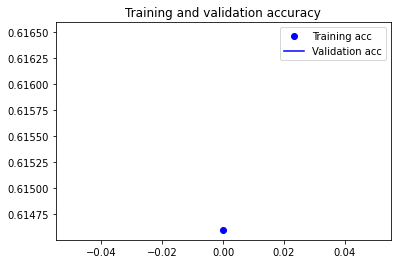

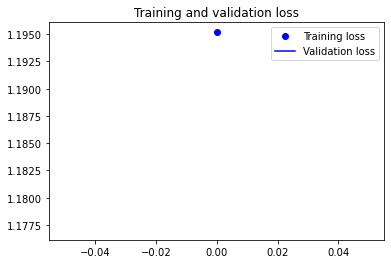

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
filenames = []
labels = []
#for f in os.listdir(os.path.join(BASE_DIR, 'test1')):
for f in os.listdir(os.path.join(BASE_DIR, 'test_images')):
    filenames.append(f)
    labels.append('0')

test_df = pd.DataFrame({
    'image_id': filenames,
    'label': labels,
})

test_datagen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(BASE_DIR, 'test_images'),
    #directory=os.path.join(BASE_DIR, 'test1'),
    x_col='image_id',
    y_col='label',
    target_size=(224, 224)
    
)

y_pred = model.predict(test_datagen)
test_df['label'] = np.argmax(y_pred, axis=1)
test_df.to_csv('submission.csv', index=False)
print(test_df)
print('Done')

Found 1 validated image filenames belonging to 1 classes.
         image_id  label
0  2216849948.jpg      3
Done
